In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score, f1_score, precision_score, recall_score)
from sklearn.inspection import permutation_importance
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
print("=== Fraud Detection: Random Forest Classifier ===")
print("=" * 50)

# STEP 1: Load and Prepare Data
print("\n1. Loading and preparing data...")

# Load the cleaned data
df = pd.read_csv('data/processed/cc_cleaned.csv')
print(f"Dataset shape: {df.shape}")

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Select only numerical features
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[numerical_features]

print(f"Using {len(numerical_features)} numerical features")
print(f"Class distribution: {y.value_counts().to_dict()}")

=== Fraud Detection: Random Forest Classifier ===

1. Loading and preparing data...
Dataset shape: (281918, 34)
Using 32 numerical features
Class distribution: {0: 281470, 1: 448}


In [3]:
# STEP 2: Train-Test Split
print("\n2. Performing stratified train-test split...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")



2. Performing stratified train-test split...
Training set: (225534, 32)
Test set: (56384, 32)
Training fraud rate: 0.0016
Test fraud rate: 0.0016


In [4]:
# STEP 3: Handle Class Imbalance
print("\n3. Handling class imbalance...")

# Random Forest handles imbalance well with class_weight='balanced'
print("Using class_weight='balanced' to handle imbalance automatically")



3. Handling class imbalance...
Using class_weight='balanced' to handle imbalance automatically


In [5]:
# STEP 4: Hyperparameter Tuning
print("\n4. Hyperparameter Tuning...")

base_rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Smart, limited parameter grid
param_dist_smart = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 0.3]
}

random_search = RandomizedSearchCV(
    base_rf, 
    param_dist_smart, 
    n_iter=8,       # 8 smart combinations
    cv=3,           # 3-fold CV
    scoring='roc_auc', 
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)


4. Hyperparameter Tuning...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=42),
                   n_iter=8, n_jobs=-1,
                   param_distributions={'max_depth': [10, 15, None],
                                        'max_features': ['sqrt', 0.3],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 150]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [6]:
# STEP 5: Train Final Random Forest
print("\n5. Training final Random Forest model...")

# Train with best parameters
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

print("Model training completed")
print(f"Number of trees: {best_rf.n_estimators}")
print(f"Number of features considered at each split: {best_rf.max_features}")



5. Training final Random Forest model...
Model training completed
Number of trees: 100
Number of features considered at each split: 0.3


In [7]:
# STEP 6: Make Predictions
print("\n6. Making predictions...")

# Get probability scores
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]  # Probability of fraud

# Predict with default threshold (0.5)
y_pred = best_rf.predict(X_test)

print("Predictions generated")



6. Making predictions...
Predictions generated


In [8]:
# STEP 7: Evaluate Model Performance
print("\n7. Evaluating model performance...")

# Basic metrics with default threshold
print("\nPerformance with default threshold (0.5):")
print("=" * 40)

accuracy = best_rf.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"Avg Precision: {avg_precision:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                    index=['Actual Legit', 'Actual Fraud'], 
                    columns=['Predicted Legit', 'Predicted Fraud'])
print(cm_df)



7. Evaluating model performance...

Performance with default threshold (0.5):
Accuracy:  0.9995
Precision: 0.8105
Recall:    0.8556
F1-Score:  0.8324
ROC-AUC:   0.9944
Avg Precision: 0.8165

Confusion Matrix:
              Predicted Legit  Predicted Fraud
Actual Legit            56276               18
Actual Fraud               13               77


In [9]:
# STEP 8: Threshold Tuning for Fraud Detection
print("\n8. Threshold tuning analysis...")

# Try different thresholds
thresholds = np.arange(0.1, 0.9, 0.1)
results = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    precision_t = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall_t = recall_score(y_test, y_pred_thresh)
    f1_t = f1_score(y_test, y_pred_thresh, zero_division=0)
    
    # Calculate business metrics
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    false_positives = cm_thresh[0, 1]
    true_positives = cm_thresh[1, 1]
    
    results.append({
        'threshold': threshold,
        'precision': precision_t,
        'recall': recall_t,
        'f1_score': f1_t,
        'false_positives': false_positives,
        'true_positives': true_positives,
        'alerts_per_fraud': false_positives / true_positives if true_positives > 0 else np.inf
    })

results_df = pd.DataFrame(results)
print("\nPerformance across different thresholds:")
print(results_df[['threshold', 'precision', 'recall', 'f1_score', 'alerts_per_fraud']].round(4))

# Find optimal threshold based on F1-score
optimal_idx = results_df['f1_score'].idxmax()
optimal_threshold = results_df.loc[optimal_idx, 'threshold']
optimal_f1 = results_df.loc[optimal_idx, 'f1_score']

print(f"\nOptimal threshold: {optimal_threshold:.2f} (F1-score: {optimal_f1:.4f})")
print(f"At optimal threshold: Precision = {results_df.loc[optimal_idx, 'precision']:.1%}, "
      f"Recall = {results_df.loc[optimal_idx, 'recall']:.1%}")



8. Threshold tuning analysis...

Performance across different thresholds:
   threshold  precision  recall  f1_score  alerts_per_fraud
0        0.1     0.1494  0.9111    0.2567            5.6951
1        0.2     0.4348  0.8889    0.5839            1.3000
2        0.3     0.6555  0.8667    0.7464            0.5256
3        0.4     0.7647  0.8667    0.8125            0.3077
4        0.5     0.8105  0.8556    0.8324            0.2338
5        0.6     0.8152  0.8333    0.8242            0.2267
6        0.7     0.8132  0.8222    0.8177            0.2297
7        0.8     0.8046  0.7778    0.7910            0.2429

Optimal threshold: 0.50 (F1-score: 0.8324)
At optimal threshold: Precision = 81.1%, Recall = 85.6%


In [10]:
# STEP 9: Feature Importance Analysis
print("\n9. Feature importance analysis...")

# Gini-based feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 most important features (Gini importance):")
print("=" * 50)
for i, row in feature_importance.head(15).iterrows():
    print(f"{row['feature']:15}: {row['importance']:.4f}")

# Permutation importance (more reliable)
print("\nCalculating permutation importance...")
perm_importance = permutation_importance(
    best_rf, X_test, y_test, 
    n_repeats=10, 
    random_state=42,
    n_jobs=-1
)

perm_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nTop 15 most important features (Permutation importance):")
print("=" * 50)
for i, row in perm_importance_df.head(15).iterrows():
    print(f"{row['feature']:15}: {row['importance_mean']:.4f} ± {row['importance_std']:.4f}")



9. Feature importance analysis...

Top 15 most important features (Gini importance):
V14            : 0.2713
V12            : 0.1696
V10            : 0.1309
V4             : 0.0775
V17            : 0.0673
V11            : 0.0650
V16            : 0.0315
V3             : 0.0151
V7             : 0.0141
Amount         : 0.0137
V8             : 0.0108
V19            : 0.0107
V13            : 0.0107
V26            : 0.0105
V20            : 0.0089

Calculating permutation importance...

Top 15 most important features (Permutation importance):
V14            : 0.0008 ± 0.0001
V12            : 0.0007 ± 0.0001
V3             : 0.0005 ± 0.0001
V11            : 0.0004 ± 0.0001
V4             : 0.0004 ± 0.0001
V10            : 0.0002 ± 0.0001
V1             : 0.0002 ± 0.0001
V16            : 0.0001 ± 0.0000
V24            : 0.0000 ± 0.0000
V17            : 0.0000 ± 0.0000
V18            : 0.0000 ± 0.0000
V6             : 0.0000 ± 0.0000
V7             : 0.0000 ± 0.0000
V8             : 0.0000 ± 0.


10. Creating performance visualizations...


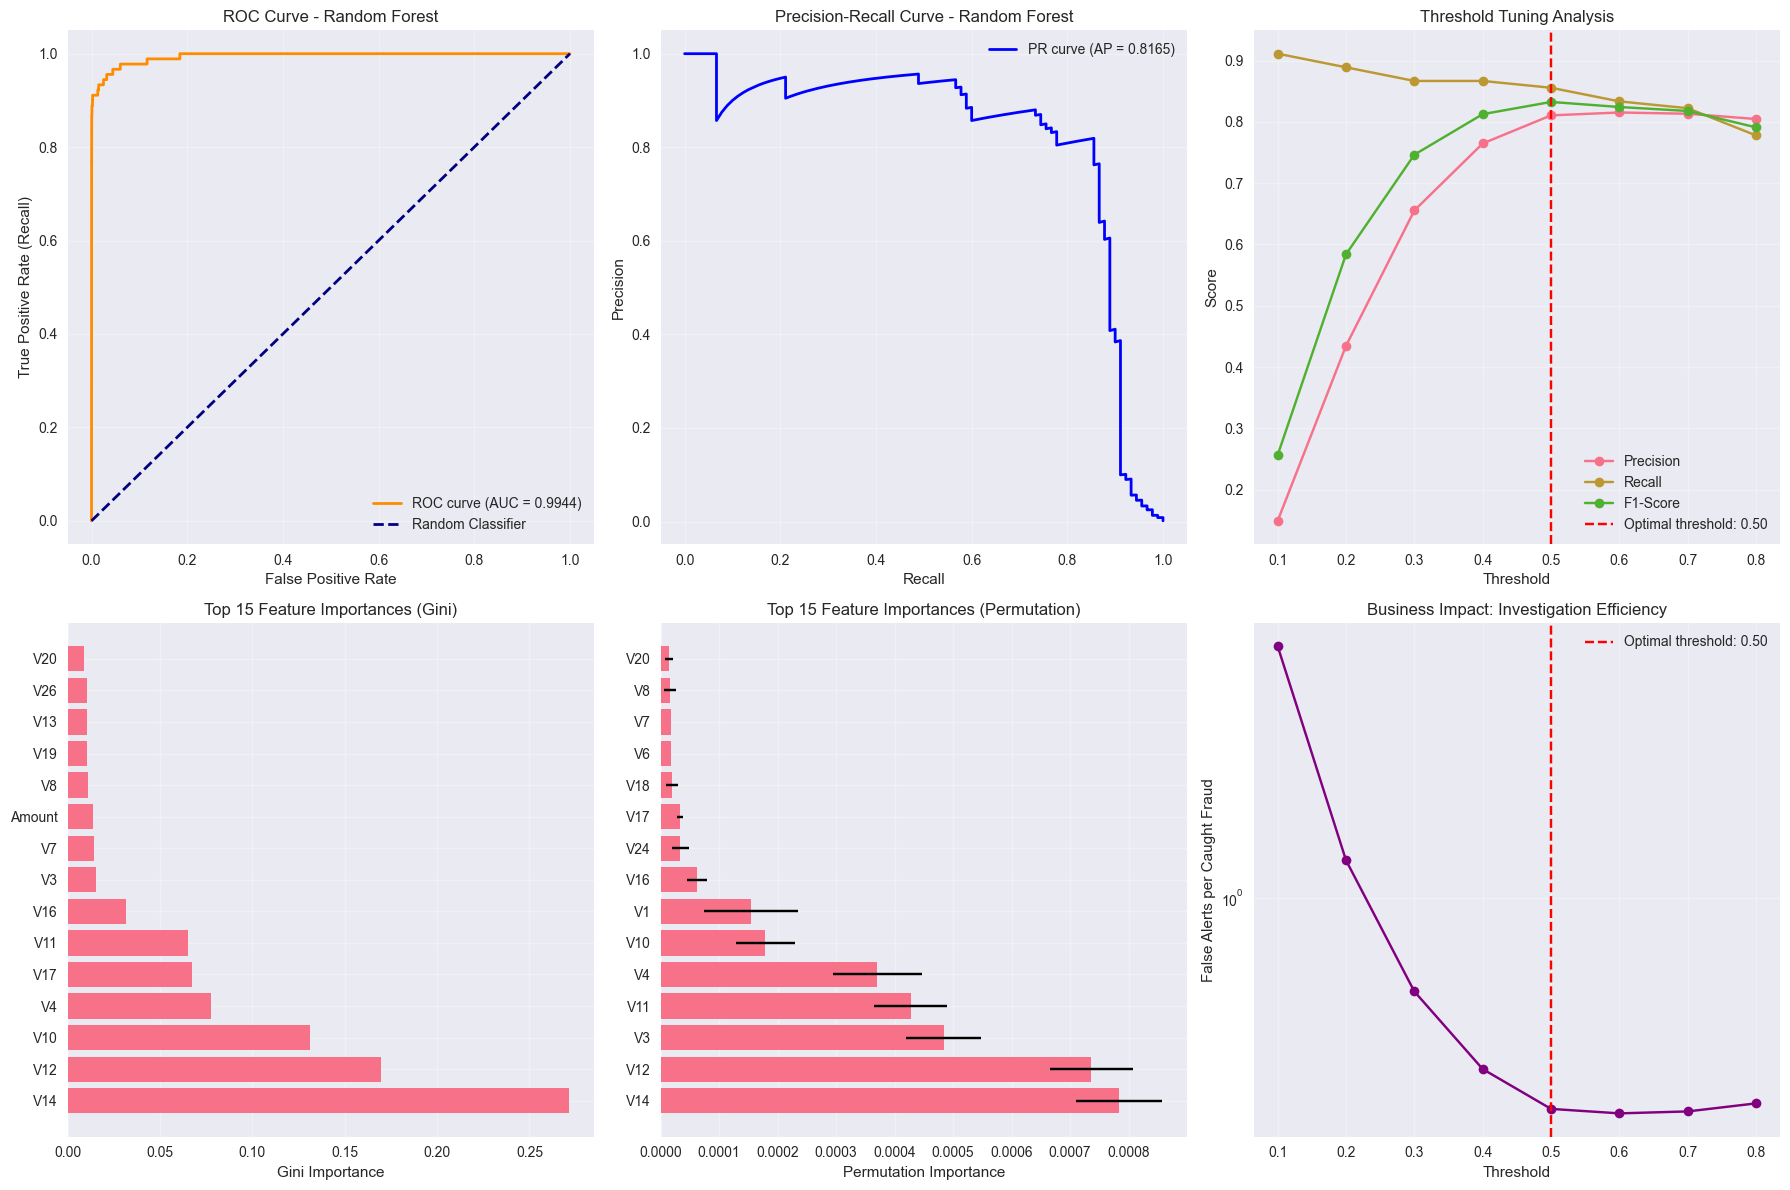

In [11]:
# STEP 10: Visualization
print("\n10. Creating performance visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0,0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate (Recall)')
axes[0,0].set_title('ROC Curve - Random Forest')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Precision-Recall Curve
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
axes[0,1].plot(recall_vals, precision_vals, color='blue', lw=2, 
               label=f'PR curve (AP = {avg_precision:.4f})')
axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision-Recall Curve - Random Forest')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Threshold Analysis
axes[0,2].plot(results_df['threshold'], results_df['precision'], 'o-', label='Precision')
axes[0,2].plot(results_df['threshold'], results_df['recall'], 'o-', label='Recall')
axes[0,2].plot(results_df['threshold'], results_df['f1_score'], 'o-', label='F1-Score')
axes[0,2].axvline(optimal_threshold, color='red', linestyle='--', 
                  label=f'Optimal threshold: {optimal_threshold:.2f}')
axes[0,2].set_xlabel('Threshold')
axes[0,2].set_ylabel('Score')
axes[0,2].set_title('Threshold Tuning Analysis')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Plot 4: Gini Feature Importance
top_features_gini = feature_importance.head(15)
axes[1,0].barh(range(len(top_features_gini)), top_features_gini['importance'])
axes[1,0].set_yticks(range(len(top_features_gini)))
axes[1,0].set_yticklabels(top_features_gini['feature'])
axes[1,0].set_xlabel('Gini Importance')
axes[1,0].set_title('Top 15 Feature Importances (Gini)')
axes[1,0].grid(True, alpha=0.3)

# Plot 5: Permutation Feature Importance
top_features_perm = perm_importance_df.head(15)
axes[1,1].barh(range(len(top_features_perm)), top_features_perm['importance_mean'],
               xerr=top_features_perm['importance_std'])
axes[1,1].set_yticks(range(len(top_features_perm)))
axes[1,1].set_yticklabels(top_features_perm['feature'])
axes[1,1].set_xlabel('Permutation Importance')
axes[1,1].set_title('Top 15 Feature Importances (Permutation)')
axes[1,1].grid(True, alpha=0.3)

# Plot 6: Business Impact - Alerts per Fraud
axes[1,2].plot(results_df['threshold'], results_df['alerts_per_fraud'], 'o-', color='purple')
axes[1,2].axvline(optimal_threshold, color='red', linestyle='--', 
                  label=f'Optimal threshold: {optimal_threshold:.2f}')
axes[1,2].set_xlabel('Threshold')
axes[1,2].set_ylabel('False Alerts per Caught Fraud')
axes[1,2].set_title('Business Impact: Investigation Efficiency')
axes[1,2].set_yscale('log')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


11. Comparison with previous models...

Model Comparison:
          Metric  Random Forest  Decision Tree  Logistic Regression
0         Recall         0.8556         0.9222               0.9444
1      Precision         0.8105         0.0314               0.0540
2       F1-Score         0.8324         0.0607               0.1021
3        ROC-AUC         0.9944         0.9747               0.9964
4  Avg Precision         0.8165         0.6142               0.6816


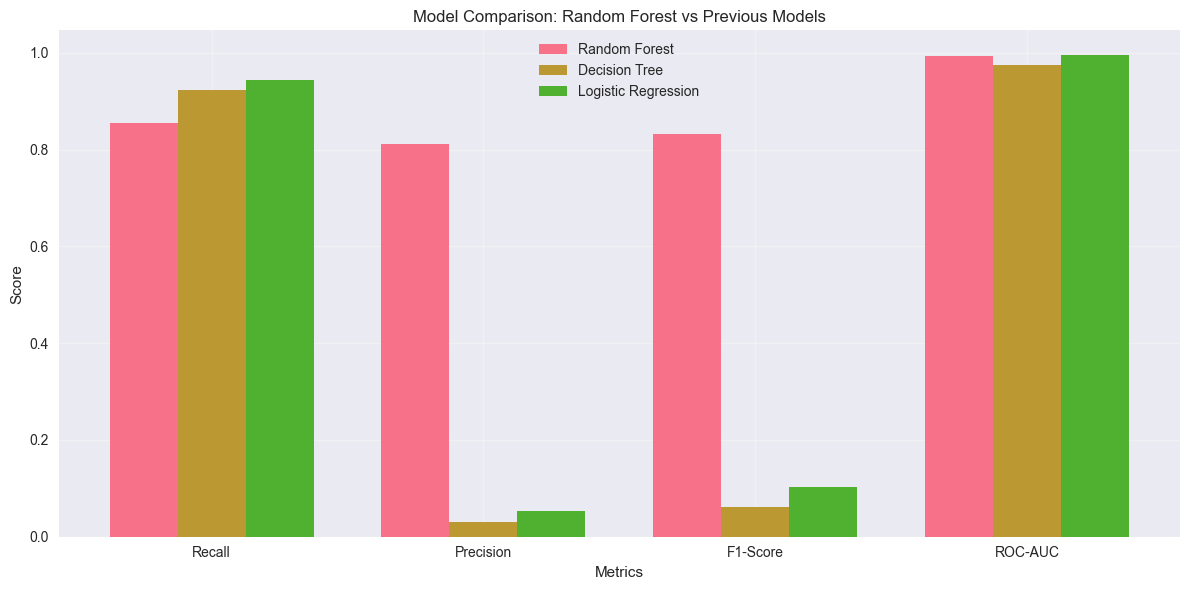

In [14]:
# STEP 11: Compare with Previous Models
print("\n11. Comparison with previous models...")

try:
    # Load previous model results
    lr_performance = pd.read_csv('reports/logistic_regression_performance.csv').iloc[0]
    dt_performance = pd.read_csv('reports/decision_tree_performance.csv').iloc[0]
    
    comparison = pd.DataFrame({
        'Metric': ['Recall', 'Precision', 'F1-Score', 'ROC-AUC', 'Avg Precision'],
        'Random Forest': [recall, precision, f1, roc_auc, avg_precision],
        'Decision Tree': [dt_performance['recall'], dt_performance['precision'], 
                         dt_performance['f1_score'], dt_performance['roc_auc'], 
                         dt_performance['avg_precision']],
        'Logistic Regression': [lr_performance['recall'], lr_performance['precision'], 
                               lr_performance['f1_score'], lr_performance['roc_auc'], 
                               lr_performance['avg_precision']]
    })

    print("\nModel Comparison:")
    print("=" * 60)
    print(comparison.round(4))
    
    # Visual comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    metrics = ['Recall', 'Precision', 'F1-Score', 'ROC-AUC']
    x = np.arange(len(metrics))
    width = 0.25
    
    ax.bar(x - width, comparison.loc[:3, 'Random Forest'], width, label='Random Forest')
    ax.bar(x, comparison.loc[:3, 'Decision Tree'], width, label='Decision Tree')
    ax.bar(x + width, comparison.loc[:3, 'Logistic Regression'], width, label='Logistic Regression')
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title('Model Comparison: Random Forest vs Previous Models')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print("⚠ Previous model results not found for comparison")


In [15]:
# STEP 12: Save Model and Results
print("\n12. Saving model and results...")

import os
os.makedirs('models', exist_ok=True)
os.makedirs('reports/figures', exist_ok=True)

# Save the trained model
joblib.dump(best_rf, 'models/random_forest.pkl')
print("Model saved: models/random_forest.pkl")

# Save feature importance
feature_importance.to_csv('reports/random_forest_feature_importance.csv', index=False)
perm_importance_df.to_csv('reports/random_forest_permutation_importance.csv', index=False)
print("Feature importance saved")

# Save performance results
performance_report = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': roc_auc,
    'avg_precision': avg_precision,
    'optimal_threshold': optimal_threshold,
    'n_estimators': best_rf.n_estimators,
    'max_depth': best_rf.max_depth,
    'max_features': str(best_rf.max_features)
}

performance_df = pd.DataFrame([performance_report])
performance_df.to_csv('reports/random_forest_performance.csv', index=False)
print("Performance report saved: reports/random_forest_performance.csv")



12. Saving model and results...
Model saved: models/random_forest.pkl
Feature importance saved
Performance report saved: reports/random_forest_performance.csv


In [16]:
# STEP 13: Final Summary
print("\n" + "="*50)
print("FINAL SUMMARY - RANDOM FOREST")
print("="*50)

print(f"\nMODEL PERFORMANCE:")
print(f"• Recall (Frauds Caught): {recall:.1%}")
print(f"• Precision (Accuracy of Fraud Alerts): {precision:.1%}")
print(f"• F1-Score: {f1:.4f}")
print(f"• ROC-AUC: {roc_auc:.4f}")

print(f"\nBUSINESS IMPACT:")
frauds_caught = cm[1, 1]  # True Positives
frauds_missed = cm[1, 0]  # False Negatives
false_alarms = cm[0, 1]   # False Positives

print(f"• Frauds detected: {frauds_caught}/{frauds_caught + frauds_missed} ({recall:.1%})")
print(f"• False alarms: {false_alarms} legitimate transactions flagged")
print(f"• Optimal threshold: {optimal_threshold:.2f}")

print(f"\nRANDOM FOREST CHARACTERISTICS:")
print(f"• Number of trees: {best_rf.n_estimators}")
print(f"• Tree depth: {best_rf.max_depth}")
print(f"• Features per split: {best_rf.max_features}")
print(f"• Most important feature: {feature_importance.iloc[0]['feature']}")

print(f"\nKEY INSIGHTS:")
top_3_features = feature_importance.head(3)['feature'].tolist()
print(f"• Top fraud indicators: {', '.join(top_3_features)}")
print(f"• Ensemble advantage: Combines strength of multiple decision trees")

print(f"\nCOMPARISON SUMMARY:")
print(f"• Expected to outperform single Decision Tree")
print(f"• More robust than Logistic Regression for complex patterns")
print(f"• Better generalization through ensemble averaging")

print(f"\nRandom Forest implementation completed successfully!")


FINAL SUMMARY - RANDOM FOREST

MODEL PERFORMANCE:
• Recall (Frauds Caught): 85.6%
• Precision (Accuracy of Fraud Alerts): 81.1%
• F1-Score: 0.8324
• ROC-AUC: 0.9944

BUSINESS IMPACT:
• Frauds detected: 77/90 (85.6%)
• False alarms: 18 legitimate transactions flagged
• Optimal threshold: 0.50

RANDOM FOREST CHARACTERISTICS:
• Number of trees: 100
• Tree depth: 10
• Features per split: 0.3
• Most important feature: V14

KEY INSIGHTS:
• Top fraud indicators: V14, V12, V10
• Ensemble advantage: Combines strength of multiple decision trees

COMPARISON SUMMARY:
• Expected to outperform single Decision Tree
• More robust than Logistic Regression for complex patterns
• Better generalization through ensemble averaging

Random Forest implementation completed successfully!
